# Minimum Viable Product (MVP) Exploration
- Create initial hypotheses using domain knowledge
    * Hypotheses: Attack categories have certain expected appearance in the dataset
- Conduct statistical testing to answer them
    * Categorical target: Use Chi Square tests and Comparison of Means tests
- Export results to Pandas for quick visualization in Seaborn

# Preparation

In [1]:
# imports
import pyspark
from pyspark.sql.functions import *
spark = pyspark.sql.SparkSession.builder.getOrCreate()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import wrangle

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/24 13:03:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# ingest, preparation, and split
df, train = wrangle.prep_explore()

In [3]:
df.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: string (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: string (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: string (nullable = true)
 |-- is_guest_login: string (nullable = true)
 |-- count: string (nullable = true)
 |-

# Initial Hypotheses
- DOS: denial-of-service, e.g. syn flood
    * Hypothesis: Anomalies have higher srv_count than normal traffic
- R2L: unauthorized access from a remote machine, e.g. guessing password
    * Hypothesis: Anomalies have higher num_failed_logins than normal traffic
- U2R:  unauthorized access to local superuser (root) privileges, e.g., various 'buffer overflow' attacks
    * Hypothesis: Anomalies have higher su_attempted than normal traffic
- probing: surveillance and other probing, e.g., port scanning
    * Hypothesis: Anomalies have higher srv_diff_host_rate than normal traffic

## Hypothesis 1: Anomalies have higher same-server request counts than normal traffic
- $H_0$: Anomalies do not have higher average same-server request count than normal traffic.
- $H_a$: Anomalies have higher average same-server request count than normal traffic.
- Confidence Interval: 95%

In [4]:
# export required columns to pandas
srv_count_target = train.select('srv_count', 'target').toPandas()

22/01/24 13:03:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


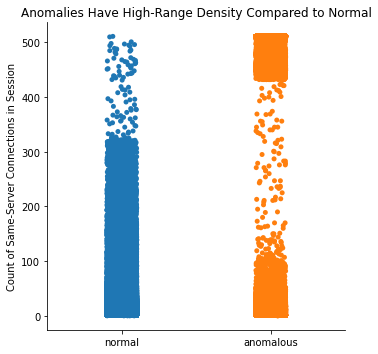

In [5]:
# visualize means
sns.catplot(data=srv_count_target.sort_values(by='target', ascending=False), 
            x='target', 
            y='srv_count', 
            kind='strip')
plt.title('Anomalies Have High-Range Density Compared to Normal')
plt.ylabel('Count of Same-Server Connections in Session')
plt.xlabel('')
plt.show()

In [6]:
# set alpha
alpha = .05

# perform statistical test
t, p = stats.mannwhitneyu(
    srv_count_target[srv_count_target.target != 'normal'].srv_count,
    srv_count_target[srv_count_target.target == 'normal'].srv_count,
    alternative='greater'
)

In [7]:
# print results
if t > 0 and p < alpha:
    print('We reject the null hypothesis. We are 95% confident that anomalies have higher srv_count than normal traffic.')
else:
    print('We accept the null hypothesis. Results do not breach the 95% confidence interval.')

We reject the null hypothesis. We are 95% confident that anomalies have higher srv_count than normal traffic.


## Hypothesis 2: Anomalies have higher failed login counts than normal traffic
- $H_0$: Anomalies do not have higher average failed login count than normal traffic.
- $H_a$: Anomalies have higher average failed login count than normal traffic.
- Confidence Interval: 95%

In [8]:
# export required columns to pandas
failed_logins_target = train.select('num_failed_logins', 'target').toPandas()

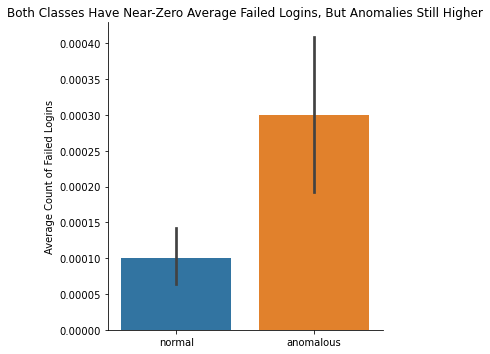

In [9]:
# visualize means
sns.catplot(data=failed_logins_target.sort_values(by='target', ascending=False), 
            x='target', 
            y='num_failed_logins', 
            kind='bar')
plt.title('Both Classes Have Near-Zero Average Failed Logins, But Anomalies Still Higher')
plt.ylabel('Average Count of Failed Logins')
plt.xlabel('')
plt.show()

In [10]:
# set alpha
alpha = .05

# perform statistical test
t, p = stats.mannwhitneyu(
    failed_logins_target[failed_logins_target.target != 'normal'].num_failed_logins,
    failed_logins_target[failed_logins_target.target == 'normal'].num_failed_logins,
    alternative='greater'
)

In [11]:
# print results
if t > 0 and p < alpha:
    print('We reject the null hypothesis. We are 95% confident that anomalies have higher count of failed logins than normal traffic.')
else:
    print('We accept the null hypothesis. Results do not breach the 95% confidence interval.')

We reject the null hypothesis. We are 95% confident that anomalies have higher count of failed logins than normal traffic.


## Hypothesis 3: Anomalies have higher superuser attempts than normal traffic
- $H_0$: Anomalies do not have higher average superuser attempts than normal traffic.
- $H_a$: Anomalies have higher average superuser attempts than normal traffic.
- Confidence Interval: 95%

In [12]:
# export required columns to pandas
su_attempts_target = train.select('su_attempted', 'target').toPandas()

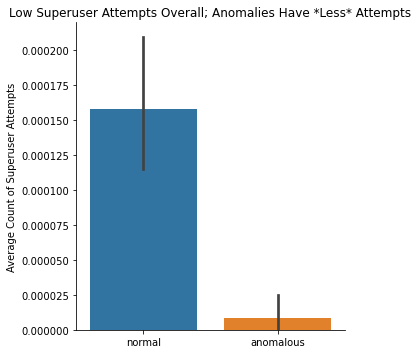

In [13]:
# visualize means
sns.catplot(data=su_attempts_target.sort_values(by='target', ascending=False), 
            x='target', 
            y='su_attempted', 
            kind='bar')
plt.title('Low Superuser Attempts Overall; Anomalies Have *Less* Attempts')
plt.ylabel('Average Count of Superuser Attempts')
plt.xlabel('')
plt.show()

In [14]:
# set alpha
alpha = .05

# perform statistical test
t, p = stats.mannwhitneyu(
    su_attempts_target[su_attempts_target.target != 'normal'].su_attempted,
    su_attempts_target[su_attempts_target.target == 'normal'].su_attempted,
    alternative='greater'
)

In [15]:
# print results
if t > 0 and p < alpha:
    print('We reject the null hypothesis. We are 95% confident that anomalies have higher superuser attempts than normal traffic.')
else:
    print('We accept the null hypothesis. Results do not breach the 95% confidence interval.')

We accept the null hypothesis. Results do not breach the 95% confidence interval.


## Hypothesis 4: Anomalies have higher different-host connection rate than normal traffic
- $H_0$: Anomalies do not have higher average different-host connection rate than normal traffic.
- $H_a$: Anomalies have higher average different-host connection rate than normal traffic.
- Confidence Interval: 95%

In [16]:
# export required columns to pandas
diff_hosts_target = train.select('srv_diff_host_rate', 'target').toPandas()

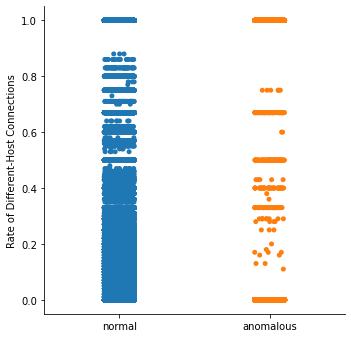

In [17]:
# visualize means
sns.catplot(data=diff_hosts_target.sort_values(by='target', ascending=False), 
            x='target', 
            y='srv_diff_host_rate', 
            kind='strip')
plt.title('')
plt.ylabel('Rate of Different-Host Connections')
plt.xlabel('')
plt.show()

### Visual Results for Different Host Rate Hypothesis
1. Due to the existence of 100%-different, it's clear that this is *not* majority_host_count / total_connection_count
2. **Because of this, we can't do a statistical test to answer our hypothesis.**